# Applied Economic Analysis: Python Assignment

|Name|examnr.|
|----|-------|
|Anwar Amezoug|101816|


# The Plankton Reveals the Whale

## Table of Content  <a id='TOC'></a>

- [Research Question](#Research_Question)
- (#Motivation')
- <a href= '#Answer'>Answer</a>
- <a href= '#A&L'>Assumptions and Limitations</a>
- <a href= '#Data'>Data</a>
- <a href= '#Pre-Processing'>Pre-Processing</a>
- <a href= '#Data_Distribution'>Data Distribution</a>
- <a href= '#Grid_Search'>Grid Search</a>
- <a href= '#Domain_Specific'>FastText Domain Specific Model:</a>
    - <a href= '#DSTwitterGender'>Twitter Gender</a>
    - <a href= '#DSRedditGender'>Reddit Gender</a>
    - <a href= '#DSTwitterAge'>Twitter Age</a>
    - <a href= '#DSRedditAge'>Reddit Age</a><p/>
    
- <a href= '#Cross_Domain'>FastText Cross-Domain Model:</a><p/>
    - <a href= '#CSTwitterGender'>Twitter Gender</a>
    - <a href= '#CSRedditGender'>Reddit Gender</a>
    - <a href= '#CSTwitterAge'>Twitter Age</a>
    - <a href= '#CSRedditAge'>Reddit Age</a><p/>
- <a href= '#Conclusion'>Conclusion</a>

## Research Question (#Research_Question)

- To what extent can anonymous social network user's gender and age be indentified for marketing, law enforcement and social engineering purposes?
- To what extent can we classify the gender and age of Twitter and Reddit users based solely on their linguistical and syntaxical features?
- To what extent is a one-fit-all model an effective method of extracting age and gender across domain?

Firstly, we will analyze to what extent the employed models are able to classify gender and age on Twitter and Reddit. Secondly, we will run a cross-domain approach to analyze the generalizability of our models across social platforms. Lastly, we answer whether the use of a one-fit-all model leads to an efficient and competitive method for extracting personal attributes such as gender and age. <a href= '#TOC'>Top</a>

## Motivation <a id='Motivation'></a>

Social networks have become a popular way for people to connect, with 1/7th of the
world’s population making use of Twitter, Reddit and Facebook regularly. This is propagated through direct messaging and the broadcasting of content. The popularity of the networks creates the opportunity to study society at a scale, by leveraging unprecedented varieties of written language. 

The field of author profiling deals with the process of deciphering information about a given author, e.g. identifying age, gender and personality, from the text he or she has written. Author profiling derives its application from the curtain of anonymity that has engulfed online communication. Author profiling is applied in fields such as security, personalized advertisements and law enforcement. While in marketing, the data is used to reveal the demographic information on the most profitable audience and subsequently create an advertisement campaign to target this group of consumers on social media. However, it could also be used in a harmful manner and result in substantial losses for the individuals and firms involved. Namely, it could be used for the uncovering and targeting vulnurable individuals for social engineering purposes.

We aim to show that a feasible and efficient machine learning algorithm can be employed with the use of a small sub sample of labeled data to reveal the attributes of anonymous users. Subsequently, the information revealed could then be used for i.e. the purposes of marketing, law enforcement and social hackers. <a href= '#TOC'>Top</a>

## Answer<a id='Answer'></a>

We demonstrate competitive performance for the Reddit age, Reddit gender, Twitter age and Twitter gender models. Furthermore, the cross-domain experiment shows that Twitter and Reddit’s gender and age models generalize well. Finally, our main contribution is the analysis of the generalizability between Reddit and Twitter where we find the information extracted by the one-fit-all model is able to efficiently extract the personal attributes of otherwise anonymous users for the purpose of marketing, law enforcement and social hacking. <a href= '#TOC'>Top</a>

## Assumption and Limitations <a id='A&L'></a>

The selected Reddit gender authors suffer from selection bias as they are exclusively sampled from the /Askwomen and /Askmen subreddit in which the authors choose to reveal their gender, which constitutes a specific sub-population that chooses to reveal their gendser. Similarly, the Reddit age authors suffer from selection biased as they are gathered through queries in which authors decide to reveal their age, which also constitutes a specific sub- population that chooses to reveal their age. However, all classification studies on social media suffer from this bias as there is no frame in place which allows to sample from all users.

Second, we made use of relatively small samples of people above the age of 40 and below the age of 20. Which is likely to explain the poorer performance of these groups.

Thirdly, the queries are able to be tuned substantially to improve the accuracy. <a href= '#TOC'>Top</a>

## Data<a id='Data'></a>

The monthly Reddit data from October 1st 2017 until May 31st 2018 was obtained from pushshift.io. The website stores the daily and monthly Reddit data dumps and goes back until December 2005. The six month data used in this study is roughly 300 gigabytes in size.
It is generally not feasible to load the data directly into memory due to the heavy memory requirements. The alternatives are to stream the monthly data line by line or set up a database and therein store the data. The relative efficiency of retrieving the flaired gender of authors was tested by comparing the retrieval time between using a NoSQL Mongo database and streaming the data line by line. Both methods were tested using the following specifications, Intel i7600k 4200 MHz quad core processor and 16 gigabytes of DDR4 ram.

The Twitter data was obtained through through the Twitter API. The Twitter API allows for the streaming and
gathering of tweets posted in real time and historical tweets of up to three weeks earlier. <a href= '#Research_Question'>Top</a>



## Pre-Processing <a id='Pre-Processing'></a>

After collecting the Twitter and Reddit data, all hyperlinks were removed from the messages. The messages were further manipulated by removing the following special characters: \t, \n and \\. Additionally, we employed the tokenization procedure of spaCy and lemmatized the datasets using the nltk package. The Twitter dataset was subject to additional pre-processing as all re-tweets were removed from the dataset.

The data was transformed from a message level analysis (1 message per author per line) to a profile level analysis (200 messages per author per line). <a href= '#TOC'>Top</a>


In [6]:
#Import libraries

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import fasttext
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#A function that transforms message level data to profile level data,
#which contains 200 messages per line instead of 1 message per line.

def batch_maker(data):
    unique_authors = np.unique(data['Name'])
    batch_dataset = []
    
    for author in unique_authors:
        author_data = pd.DataFrame()
        author_data['Body'] = data['Body'].where(data['Name'] == author)
        author_data['Label'] = data['Label'].where(data['Name'] == author)
        author_data = author_data.dropna()

        author_data = author_data.reset_index()

        if author_data.shape[0] < 200:
            continue

        else:
            for x in range(200,author_data.shape[0], 200):
                batch_data = author_data[(x-200):x]
                batch_body = batch_data.Body.str.cat(sep=' ')
                batch_label = author_data.Label[0]

                batch_dataset.append([batch_body,batch_label])
        
    return pd.DataFrame(batch_dataset)

In [3]:
#Load Data Batched and Split Data.

#Twitter Age Dataset: X_test, X_train, y_test
df_t_X_test_age = pd.read_csv("X_test_age_volk.csv")
df_t_X_train_age = pd.read_csv("X_train_age_volk.csv", names = ['Text','Label'], sep = "__label__")
df_t_y_test_age = pd.read_csv("y_test_age_volk.csv", names = ['Label'])

#Twitter Gender Dataset: X_test, X_train, y_test
df_t_X_test_gender = pd.read_csv("X_test_volk.csv")
df_t_X_train_gender = pd.read_csv("X_train_volk.csv", names = ['Text','Label'], sep = "__label__")
df_t_y_test_gender = pd.read_csv("y_test_volk.csv")

#Reddit Age Dataset: X_test, X_train, y_test
df_r_X_test_age = pd.read_csv("X_test_r_age_batch.csv")
df_r_X_train_age = pd.read_csv("X_train_r_age_batch.csv", names = ['Text','Label'], sep = "__label__")
df_r_y_test_age = pd.read_csv("y_test_r_age_batch.csv")

#Reddit Gender Dataset: X_test, X_train, y_test
df_r_X_test_gender = pd.read_csv("X_test_r_gender_batch.csv")
df_r_X_train_gender = pd.read_csv("X_train_r_gender_batch.csv", names = ['Text','Label'], sep = "__label__")
df_r_y_test_gender = pd.read_csv("y_test_r_gender_batch.csv")

/Users/anwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """
/Users/anwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.
/Users/anwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='py

In [4]:
#Dataset Shape
print("The 'Twitter Age' dataset has: {:10} columns and {} rows.".format((df_t_X_test_age.shape[0] + df_t_X_train_age.shape[0]),(df_t_X_train_age.shape[1])))
print("The 'Twitter Gender' dataset has: {:7} columns and {} rows.".format((df_t_X_test_gender.shape[0] + df_t_X_train_gender.shape[0]),(df_t_X_train_gender.shape[1])))
print("The 'Reddit Age' dataset has: {:11} columns and {} rows.".format((df_r_X_test_age.shape[0] + df_r_X_train_age.shape[0]),(df_r_X_train_age.shape[1])))
print("The 'Reddit Gender' dataset has: {:8} columns and {} rows.".format((df_r_X_test_gender.shape[0] + df_r_X_train_gender.shape[0]),(df_r_X_train_gender.shape[1])))

The 'Twitter Age' dataset has:      36786 columns and 2 rows.
The 'Twitter Gender' dataset has:   36786 columns and 2 rows.
The 'Reddit Age' dataset has:       31948 columns and 2 rows.
The 'Reddit Gender' dataset has:    17972 columns and 2 rows.


## Data Distribution <a id='Data_Distribution'></a>

The violin plots shown in Figure 1 display the author age distribution and the post
frequency distribution for the Twitter- and Reddit age datasets. Figure 1 (a) and Figure 1
(b) show that the author age distribution and post frequency distribution for the Reddit
age dataset are leptokurtic, as they exhibits positive excess kurtosis relative to a normal
distribution. While, Twitter’s author age distribution and post frequency distribution
are platykurtic, as they exhibits negative excess kurtosis relative to a normal distribution. Furthermore, both distributions are skewed to the right, indicating that younger users are more prevalent on the platform. The distributions also indicate that Reddit’s
authors span more evenly across the age groups, while Twitter’s authors are relatively
more centered between 18 and 25 years old. Lastly, we find that Reddit users between
the age of 15-20 years old have the highest ratio of posts to number of authors, which
indicates that this category is more active on the platform than other age categories are. <a href= '#TOC'>Top</a>

Text(0.5,0,"1(a). Author's Age Distribution")

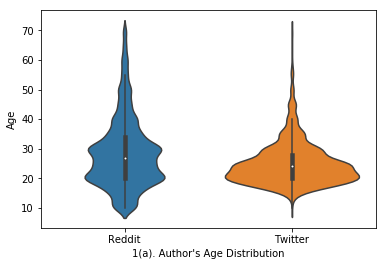

In [8]:
#Filter the dataframes from ages higher than 70 and below 10.
#Furthermore, the restructure the data such that it can be used to
#create a merged violin plot and thereby show the distribution of the
#data.

df_age_data = pd.read_csv("Reddit_Authors_Filtered_Duplicates_Bots_Truth_Labels_Age.csv")
df_age_data = df_age_data[df_age_data['Age'] < 71]
df_age_data['Label'] = 'Reddit'

df_age_data2 = pd.read_csv("Twitter_Authors_Filtered_Duplicate_Bots_With_Truth_Labels.csv")
df_age_data2 = df_age_data2[df_age_data2['Age'] < 71]
df_age_data2 = df_age_data2[df_age_data2['Age'] > 9]
df_age_data2['Label'] = 'Twitter'

test = pd.concat([df_age_data['Age'], df_age_data2['Age']], axis = 0)
test = test.reset_index()
del(test['index'])

test2 = pd.concat([df_age_data['Label'], df_age_data2['Label']], axis = 0)
test2 = test2.reset_index()
del(test2['index'])

test3 = pd.concat([test['Age'],test2['Label']], axis = 1)

fig, ax = plt.subplots()
sns.violinplot(x = test3['Label'], y=test3['Age'] , axes = ax, orient= 'v')
ax.set_xlabel("1(a). Author's Age Distribution")


Text(0.5,0,'The post distribution per age group')

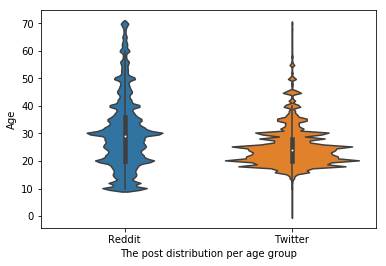

In [11]:
truth_labels = pd.read_csv("Reddit_Authors_Filtered_Duplicates_Bots_Truth_Labels_Age.csv")

#Counts the number of posts per age category for the Reddit Age Data
age = []
post = []
for x in range(10,71):
    post.append(sum(truth_labels['Posts'][truth_labels['Age'] == x]))
    age.append(x)
    
#Creates a new DataFrame to save age & number of posts in
news = pd.DataFrame()

for x in range(len(age)):
    boo = np.zeros(post[x])
    boo = np.where(boo == 0, age[x], boo)
    boo = pd.DataFrame(boo)

    news = news.append(boo)
    
news.columns = ['Age']
news = news.reset_index()
news['Label'] = 'Reddit'

truth_labels = pd.read_csv("Twitter_Authors_Filtered_Duplicate_Bots_With_Truth_Labels.csv")

##Counts the number of posts per age category for the Twitter Age Data
age = []
post = []
for x in range(10,71):
    post.append(sum(truth_labels['Count'][truth_labels['Age'] == x]))
    age.append(x)
    
#Creates a new DataFrame to save age & number of posts in    
newss = pd.DataFrame()

#Matches the age with the number of posts and manually adds a 0
#if the age category has no post count, instead of skipping it.
for x in range(len(age)):
    if post[x] != 0:
        boo = np.zeros(post[x])
        boo = np.where(boo == 0, age[x], boo)
        boo = pd.DataFrame(boo)

        newss = newss.append(boo)
    else:
        boo = [0]
        boo = pd.DataFrame(boo)
        newss = newss.append(boo)
    
newss.columns = ['Age']
newss = newss.reset_index()
newss['Label'] = 'Twitter'

#Creates the violin plot
dataset_done = pd.concat([news['Age'],newss['Age']], axis = 0)
dataset_done2 = pd.concat([news['Label'], newss['Label']], axis = 0)

data_freq = pd.concat([dataset_done, dataset_done2], axis = 1)

fig, ax = plt.subplots()
sns.violinplot(x = data_freq['Label'], y=data_freq['Age'] , axes = ax, orient= 'v')
ax.set_xlabel("1(b). The post distribution per age group")



## Grid Search <a id='Grid_Search'></a>

The data has pre-processed and has been split according to the fastText algorithms specifications. However, the fastText algorithm has several hyperparameters that require optimization. In order to do so, we create a gridsearch function which runs over an arbitrary range per hyperparameter. An arbitrary range of hyperparameters was chosen in order to finish the optimization in a feasible timeframe. <a href= '#TOC'>Top</a>

In [161]:
#A function that performs the gridsearch on the variables mentioned
#in the function's name, specifically for the Reddit Age Batch Data.

#In order to run the code for the other datasets, replace 
#the file names on the lines marked with :(1), (2), (3)
def grid_search(dim, lr, wordngrams, mincount, minn, maxn, bucket, epoch, ws):
    model = fasttext.supervised("X_train_r_age_batch.csv", "test_model", dim = dim, lr = lr, word_ngrams = wordngrams,
                                min_count = mincount, minn = minn, maxn = maxn, bucket = bucket, epoch = epoch , ws = ws) #(1)
    
    X_test = pd.read_csv("X_test_r_age_batch.csv", names = ['text']) #(2)
    y_pred = model.predict(X_test['text'])
    y_true = pd.read_csv("y_test_r_age_batch.csv", names = ['Label']) #(3)
    y_true['Label'] = y_true['Label'].apply(lambda x: x[9:])
    y_true = y_true['Label'].tolist()
    accuracy = accuracy_score(y_pred, y_true)
    print(("dim:",dim, "lr:",lr, "wordngram:",wordngrams,"mincount:",mincount,"minn:",minn,"maxn:", maxn, 
            "bucket:",bucket,"epoch:", epoch,"ws:", ws, "accuracy:", accuracy))
    return ("dim:",dim, "lr:",lr, "wordngram:",wordngrams,"mincount:",mincount,"minn:",minn,"maxn:", maxn, 
            "bucket:",bucket,"epoch:", epoch,"ws:", ws, "accuracy:", accuracy)
    

In [ ]:
from sklearn.grid_search import ParameterGrid

#A dictionary that contains a range of values per hyperparameter
#that will be optimizer through a gridsearch

param_grid = {'epoch' : [10, 20 , 30 ,40, 50, 100],
'dim' : [10, 20 , 30 , 40 ,50 , 100],
'lr' : [0.001, 0.01, 0.05, 0.1, 0.2],
'wordngrams' : [1,2,3],
'mincount' : [1,2,3,4],
'minn' : [1,2,3,4],
'maxn' : [1,2,3,4],
'bucket' : [100000, 1000000, 2000000, 5000000, 10000000],
'ws': [3,4,6]}


grid = ParameterGrid(param_grid)
results = []

for params in grid:
    results.append(grid_search(params['dim'], params['lr'], params['wordngrams'], params['mincount'], params['minn'],
                params['maxn'],params['bucket'], params['epoch'],params['ws']))



# FastText Domain Specific Model<a id='Domain_Specific'></a>

The models make use of the optimized hyperparameters that were found through the gridsearch and are considered domain specific as the models trained on the Twitter (Reddit) data are only tested on Twitter (Reddit) data. The findings suggest that the models perform substantially better than the majoirty baseline. Suggesting that the fast and effective fastText models can be employed in the real world to extract personal attributes such as age and gender.

- The Twitter Gender model reaches accuracy levels of 90.2%, relative to a majority baseline of 55.6%. 
- The Reddit Gender model reaches accuracy leels of 84.9%, relative to the majority baseline of 50.3%. 
- The Twitter Age model reaches accuracy levels of 86.2%, relative to a majority baseline of 65.6%. 
- The Reddit Age model reaches accuracy levels of 65%, relative to a majority baseline of 55.5%.  <a href= '#TOC'>Top</a>

## Model Twitter Gender <a id='DSTwitterGender'></a>  

 <a href= '#TOC'>Top</a>

In [ ]:
#Optimal hyperparameters find in gridsearch
epoch = 100
lr = 0.2
dim = 70
bucket = 5000000
wordngram = 1
mincount = 1
ws = 7

In [ ]:
    #Twitter Gender
    X_train_t = pd.read_csv("X_train_volk.csv", names =['Body', 'Label'], sep = "__label__")
    X_train_t = X_train_t.applymap(str)
    X_train_t['Label'] = "__label__" + X_train_t['Label']
    X_test = pd.read_csv("X_test_volk.csv", names = ["text"])
    y_test = pd.read_csv("y_test_volk.csv", names = ["Label"])


    X_train_t.to_csv("Train.csv", header = False, index = False, sep = " ")

    model = fasttext.supervised("Train.csv", "test_model", lr = lr, epoch = epoch , dim = dim, bucket = bucket, word_ngrams = wordngram, min_count = mincount, ws = ws)
    y_pred = model.predict(X_test['text'])
    y_true = y_test.copy()
    y_true['Label'] = y_true['Label'].apply(lambda x: x[9:])
    y_true = y_true['Label'].tolist()
    accuracy = accuracy_score(y_pred, y_true)
    print(accuracy , model.maxn , model.minn)

## Model Reddit Gender <a id='DSRedditGender'></a>

 <a href= '#TOC'>Top</a>

In [ ]:
#Optimal hyperparameters find in gridsearch
lr = 0.1
dim = 10
bucket = 7000000
wordngram = 2
mincount = 0
ws = 3

In [ ]:
    #Reddit Gender
    parameters = []    
    X_train = pd.read_csv("X_train_r_gender_batch.csv", names =['Body', 'Label'], sep = "__label__")
    X_train['Label'] = "__label__" + X_train['Label']
    X_test = pd.read_csv("X_test_r_gender_batch.csv", names = ['text'])
    y_test = pd.read_csv("y_test_r_gender_batch.csv", names = ['Label'])
    
    X_train = X_train

    X_train.to_csv("Train.csv", header = False, index = False, sep = " ")
    
    
    results = []
    epoch = 100
    
    model = fasttext.supervised("Train.csv", "test_model", lr = lr, epoch = epoch , dim = dim, bucket = bucket, word_ngrams = wordngram, min_count = mincount, ws = ws, maxn = 3, minn = 0)
    y_pred = model.predict(X_test['text'])
    y_true = pd.read_csv("y_test_r_gender_batch.csv", names = ['Label'])
    y_true['Label'] = y_true['Label'].apply(lambda x: x[9:])
    y_true = y_true['Label'].tolist()
    accuracy = accuracy_score(y_pred, y_true)
    print(accuracy)

## Model Twitter Age<a id='DSTwitterAge'></a>

 <a href= '#TOC'>Top</a>

In [ ]:
#Optimal hyperparameters find in gridsearch
epoch = 100
lr = 0.05
dim = 50
bucket = 5000000
wordngram = 1
mincount = 1
ws = 7
maxn = 1
minn = 0

In [ ]:
    #Twitter Age
    
    X_train_t = pd.read_csv("X_train_age_volk.csv", names =['Body', 'Label'], sep = "__label__")
    X_train_t = X_train_t.applymap(str)
    X_train_t['Label'] = "__label__" + X_train_t['Label']
    X_test_t = pd.read_csv("X_test_age_volk.csv", names = ["text"])
    y_test_t = pd.read_csv("y_test_age_volk.csv", names = ["Label"])
    
   
    X_train = X_train_t
    X_test = X_test_t
    y_test = y_test_t
    
    X_train.to_csv("Train.csv", header = False, index = False, sep = " ")
    model = fasttext.supervised("Train.csv", "test_model", lr = lr, epoch = epoch , dim = dim, bucket = bucket, word_ngrams = wordngram, min_count = mincount, ws = ws, maxn = maxn, minn = minn)
    y_pred = model.predict(X_test['text'])
    y_true = y_test.copy()
    y_true['Label'] = y_true['Label'].apply(lambda x: x[9:])
    y_true = y_true['Label'].tolist()
    accuracy = accuracy_score(y_pred, y_true)
    print(accuracy)

## Model Reddit Age <a id='DSRedditAge'></a>

 <a href= '#TOC'>Top</a>

In [ ]:
#Optimal hyperparameters find in gridsearch
epoch = 100
lr = 0.05
dim = 50
bucket = 10000000
wordngram = 2
mincount = 2
ws = 3
maxn = 0
minn = 0

In [ ]:
    #Reddit Age
    #Reddit
    X_train_r = pd.read_csv("X_train_r_age_batch.csv", names =['Body', 'Label'], sep = "__label__")
    X_train_r = X_train_r.applymap(str)
    X_train_r['Label'] = "__label__" + X_train_r['Label']
    X_test_r = pd.read_csv("X_test_r_age_batch.csv", names = ["text"])
    y_test_r = pd.read_csv("y_test_r_age_batch.csv", names = ["Label"])
    
    X_train = X_train_r
    X_train = X_train.reset_index()
    X_test = X_test_r
    y_test = y_test_r

    X_train.to_csv("Train.csv", header = False, index = False, sep = " ")
    
    model = fasttext.supervised("Train.csv", "test_model", lr = lr, epoch = epoch , dim = dim, bucket = bucket, word_ngrams = wordngram, min_count = mincount, ws = ws, maxn = maxn, minn = minn)
    y_pred = model.predict(X_test['text'])
    y_true = y_test.copy()
    y_true['Label'] = y_true['Label'].apply(lambda x: x[9:])
    y_true = y_true['Label'].tolist()
    accuracy = accuracy_score(y_pred, y_true)
    
    print(accuracy)

## FastText Cross-Domain Models <a id='Cross_Domain'></a>

The cross-domain experiment suggests that the Twitter and Reddit, age and gender models generalize well across platform and generalize even better when training the models on mixed data. Which indicate that the training rules learned compliment each other. Secondly, we found that the gender models that were trained on mixed data suffered from high levels of diminishing returns after adding more than 20% data from the other platform. Thirdly, we show that one fit-all model demonstrates competitive performance. <a href= '#TOC'>Top</a>

## Model Twitter Gender<a id='CSTwitterGender'></a>

Individual accuracy scores for the gender cross-domain experiment between Twitter and Reddit, in which every loop depicts an additional iteration that adds 10% of the Reddit’s training data to that of Twitter’s training data. <a href= '#TOC'>Top</a>

In [13]:
#Accuracy fasttext model
def accuracy_model(X_test, y_test, classifiers):
        y_test['Label2'] = y_test['Label'].apply(lambda x: x[9:])
        
        results = classifiers.predict(X_test['Body'])
        return (accuracy_score(results, y_test['Label2']))

def twitter_to_reddit(test_size):
    #Twitter
    X_train_t = pd.read_csv("X_train_volk.csv", names =['Body', 'Label'], sep = "__label__")
    X_train_t = X_train_t.applymap(str)
    X_train_t['Label'] = "__label__" + X_train_t['Label']
    X_test_t = pd.read_csv("X_test_volk.csv", names = ["Body"])
    y_test_t = pd.read_csv("y_test_volk.csv", names = ["Label"])
    
    data_train_gender_t = X_train_t

    
    
    #Reddit
    X_train_r = pd.read_csv("X_train_r_gender_batch.csv", names =['Body', 'Label'], sep = "__label__")
    X_train_r = X_train_r.applymap(str)
    X_train_r['Label'] = "__label__" + X_train_r['Label']
    X_test_r = pd.read_csv("X_test_r_gender_batch.csv", names = ["Body"])
    y_test_r = pd.read_csv("y_test_r_gender_batch.csv", names = ["Label"])
    
    data_train_gender_r = X_train_r
    

    #New Dataset
    X, y = data_train_gender_r['Body'], data_train_gender_r['Label']
    X_train, X_extra, y_train, y_extra = train_test_split(X, y, test_size= test_size, random_state=42)

    #Merge Datasets
    X_train = pd.DataFrame(X_extra, columns = ["Body"])
    y_train = pd.DataFrame(y_extra, columns = ["Label"])
    extra_data = pd.concat([y_train,X_train], axis = 1)


    #Finished Dataset
    data_train_gender_t = extra_data.append(data_train_gender_t)
    data_train_gender_t = data_train_gender_t.reset_index()

    
    X, y = data_train_gender_t['Body'], data_train_gender_t['Label']
    
    #Training Data
    y_train, X_train = pd.DataFrame(y, columns = ['Label']), pd.DataFrame(X, columns = ['Body'])


    #Train Data with Labels
    X_train = pd.concat([y_train, X_train ], axis = 1)
  
    X_train.to_csv("X_train.csv", header = False, index = False, sep = " ")
    
    results_r = []
    results_t = []
    
    for x in range(5):

        #Train Fasttext
        classifiers = fasttext.supervised("X_train.csv", "twitters_model", epoch = 40, lr = 0.10)

        results_r.append(accuracy_model(X_test_r, y_test_r,classifiers))
        results_t.append(accuracy_model(X_test_t, y_test_t,classifiers))

    average_r = sum(results_r)/len(results_r)
    average_t = sum(results_t)/len(results_t)
    

    print([str(test_size)+" Twitter Gender", average_r,np.std(results_r), average_t,np.std(results_t)])

    return thesis_results.append([str(test_size)+"R", "Gender", average_r,np.std(results_r), average_t,np.std(results_t)])
                                                                 
test_size = [0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]

for x in test_size:
    twitter_to_reddit(x)




NameError: name 'pandas' is not defined

<img src="AppendixB.png" />

## Model Reddit Gender <a id='CSRedditGender'></a>

Individual accuracy scores for the gender cross-domain experiment between Reddit and Twitter, in which every loop depicts an additional iteration that adds 10% of the Twitter’s training data to that of Reddit’s training data. <a href= '#TOC'>Top</a>

In [ ]:
#Accuracy fasttext model
def accuracy_model(X_test, y_test, classifiers):
        y_test['Label2'] = y_test['Label'].apply(lambda x: x[9:])
        
        results = classifiers.predict(X_test['Body'])
        return (accuracy_score(results, y_test['Label2']))


def reddit_to_twitter(test_size):
    #Twitter
    X_train_t = pd.read_csv("X_train_volk.csv", names =['Body', 'Label'], sep = "__label__")
    X_train_t = X_train_t.applymap(str)
    X_train_t['Label'] = "__label__" + X_train_t['Label']
    X_test_t = pd.read_csv("X_test_volk.csv", names = ["Body"])
    y_test_t = pd.read_csv("y_test_volk.csv", names = ["Label"])
    
    data_train_gender_t = X_train_t

    
    
    #Reddit
    X_train_r = pd.read_csv("X_train_r_gender_batch.csv", names =['Body', 'Label'], sep = "__label__")
    X_train_r = X_train_r.applymap(str)
    X_train_r['Label'] = "__label__" + X_train_r['Label']
    X_test_r = pd.read_csv("X_test_r_gender_batch.csv", names = ["Body"])
    y_test_r = pd.read_csv("y_test_r_gender_batch.csv", names = ["Label"])
    
    data_train_gender_r = X_train_r

    
      
    #New Dataset
    X, y = data_train_gender_t['Body'], data_train_gender_t['Label']
    X_train, X_extra, y_train, y_extra = train_test_split(X, y, test_size= test_size, random_state=42)

    #Merge Datasets
    X_train = pd.DataFrame(X_extra, columns = ["Body"])
    y_train = pd.DataFrame(y_extra, columns = ["Label"])
    extra_data = pd.concat([y_train,X_train], axis = 1)


    #Finished Dataset
    data_train_gender_r = extra_data.append(data_train_gender_r)
    data_train_gender_r = data_train_gender_r.reset_index()
    

    #Train data
    X, y = data_train_gender_r['Body'], data_train_gender_r['Label']
    y_train, X_train = pd.DataFrame(y, columns = ['Label']), pd.DataFrame(X, columns = ['Body'])


    #Train Data with Labels
    X_train = pd.concat([y_train, X_train ], axis = 1)


    X_train.to_csv("X_train.csv", header = False, index = False, sep = " ")

    results_r = []
    results_t = []
    
    for x in range(5):

        #Train Fasttext
        classifierz = fasttext.supervised("X_train.csv", "reddits_model", epoch = 40, lr = 0.10)

        results_r.append(accuracy_model(X_test_r, y_test_r,classifierz))
        results_t.append(accuracy_model(X_test_t, y_test_t,classifierz))


    average_r = sum(results_r)/len(results_r)
    average_t = sum(results_t)/len(results_t)
    

    print([str(test_size)+" Reddit Gender", average_r,np.std(results_r), average_t,np.std(results_t)])

    return thesis_results.append([str(test_size)+"T", "Gender", average_r,np.std(results_r), average_t,np.std(results_t)])
                                 
                                 
test_size = [0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]

for x in test_size:
    reddit_to_twitter(x)





<img src="AppendixC.png" />

## Model Twitter Age<a id='CSTwitterAge'></a>

Individual accuracy score for the age cross-domain experiment between Twitter and Reddit, in which every loop depicts an additional iteration that adds 10% of the Reddit’s training data to that of Twitter’s training data. <a href= '#TOC'>Top</a>

In [ ]:
#Accuracy fasttext model
def accuracy_model(X_test, y_test, classifierc):
    y_test['Label2'] = y_test['Label'].apply(lambda x: x[9:])
    
    results = classifierc.predict(X_test['Body'])
    
    return (accuracy_score(results, y_test['Label2']))

def twitter_to_reddit(testsize, reddit, twitter):
    
    if testsize == 0:
        X, y = twitter['Body'], twitter['Label']
        y_train, X_train = pd.DataFrame(y, columns = ['Label']), pd.DataFrame(X, columns = ['Body'])
        X_train = pd.concat([y_train, X_train ], axis = 1)
        
        X_train.to_csv("X_train.csv", header = False, index = False, sep = " ")
        
        
        results_r = []
        results_t = []

        for x in range(5):

            #Train Fasttext
            classifierc = fasttext.supervised("X_train.csv", "twitter_age_model", epoch = 40, lr = 0.10)

            results_r.append(accuracy_model(X_test_r, y_test_r,classifierc))
            results_t.append(accuracy_model(X_test_t, y_test_t,classifierc))        


        average_r = sum(results_r)/len(results_r)
        average_t = sum(results_t)/len(results_t)


        print([str(testsize)+" Twitter Age", average_r,np.std(results_r), average_t,np.std(results_t)])
        
    else:   
        #New Dataset

        X, y = reddit['Body'], reddit['Label']
        X_train, X_extra, y_train, y_extra = train_test_split(X, y, test_size= testsize, random_state=42)

        #Merge Datasets
        X_train = pd.DataFrame(X_extra, columns = ["Body"])
        y_train = pd.DataFrame(y_extra, columns = ["Label"])
        extra_data = pd.concat([y_train,X_train], axis = 1)


        #Finished Dataset
        data = extra_data.append(twitter)
        data = data.reset_index()

        X, y = data['Body'], data['Label']
        y_train, X_train = pd.DataFrame(y, columns = ['Label']), pd.DataFrame(X, columns = ['Body'])


        #Train Data with Labels
        X_train = pd.concat([y_train, X_train ], axis = 1)
        
        X_train.to_csv("X_train.csv", header = False, index = False, sep = " ")

        results_r = []
        results_t = []

        for x in range(5):

            #Train Fasttext
            classifierc = fasttext.supervised("X_train.csv", "twitter_age_model", epoch = 40, lr = 0.10)

            results_r.append(accuracy_model(X_test_r, y_test_r,classifierc))
            results_t.append(accuracy_model(X_test_t, y_test_t,classifierc)) 

        average_r = sum(results_r)/len(results_r)
        average_t = sum(results_t)/len(results_t)


        print([str(testsize)+" Twitter Age", average_r,np.std(results_r), average_t,np.std(results_t)])




    return thesis_results.append([str(testsize)+"R", "Age", average_r,np.std(results_r), average_t,np.std(results_t)])
                            

test_size = [0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99]

for x in test_size:
    twitter_to_reddit(x, data_train_gender_r, data_train_gender_t)



<img src="AppendixE.png" />

## Model Reddit Age<a id='CSRedditAge'></a>

Individual accuracy scores for the age cross-domain experiment between Reddit and Twitter, in which every loop depicts an additional iteration that adds 10% of the Twitter’s training data to that of Reddit’s training data. <a href= '#TOC'>Top</a>

In [ ]:
#Accuracy fasttext model
def accuracy_model(X_test, y_test,classifierq):
    y_test['Label2'] = y_test['Label'].apply(lambda x: x[9:])
    
    results = classifierq.predict(X_test['Body'])
    
    return (accuracy_score(results, y_test['Label2']))

In [ ]:
    #Twitter
    X_train_t = pd.read_csv("X_train_age_volk.csv", names =['Body', 'Label'], sep = "__label__")
    X_train_t = X_train_t.applymap(str)
    X_train_t['Label'] = "__label__" + X_train_t['Label']
    X_test_t = pd.read_csv("X_test_age_volk.csv", names = ["Body"])
    y_test_t = pd.read_csv("y_test_age_volk.csv", names = ["Label"])
    
   
    data_train_gender_t = X_train_t
    
    #Reddit
    X_train_r = pd.read_csv("X_train_r_age_batch.csv", names =['Body', 'Label'], sep = "__label__")
    X_train_r = X_train_r.applymap(str)
    X_train_r['Label'] = "__label__" + X_train_r['Label']
    X_test_r = pd.read_csv("X_test_r_age_batch.csv", names = ["Body"])
    y_test_r = pd.read_csv("y_test_r_age_batch.csv", names = ["Label"])
    
    data_train_gender_r = X_train_r
    
    data_train_gender_r = data_train_gender_r.reset_index()

In [ ]:
def reddit_to_twitter(testsize, reddit, twitter):
    if testsize == 0:
        X, y = reddit['Body'], reddit['Label']
        y_train, X_train = pd.DataFrame(y, columns = ['Label']), pd.DataFrame(X, columns = ['Body'])
        X_train = pd.concat([y_train, X_train ], axis = 1)
        
        X_train.to_csv("X_train.csv", header = False, index = False, sep = " ")
        
        results_r = []
        results_t = []

        for x in range(5):

            #Train Fasttext
            classifierq = fasttext.supervised("X_train.csv", "reddit_age_model", epoch = 40, lr = 0.10)

            results_r.append(accuracy_model(X_test_r, y_test_r,classifierq))
            results_t.append(accuracy_model(X_test_t, y_test_t,classifierq))
      

        average_r = sum(results_r)/len(results_r)
        average_t = sum(results_t)/len(results_t)
    

        print([str(testsize)+" Reddit Age", average_r,np.std(results_r), average_t,np.std(results_t)])
        
    else:   
        #New Dataset

        X, y = twitter['Body'], twitter['Label']
        X_train, X_extra, y_train, y_extra = train_test_split(X, y, test_size= testsize, random_state=42)

        #Merge Datasets
        X_train = pd.DataFrame(X_extra, columns = ["Body"])
        y_train = pd.DataFrame(y_extra, columns = ["Label"])
        extra_data = pd.concat([y_train,X_train], axis = 1)


        #Finished Dataset
        data = extra_data.append(reddit)
        data = data.reset_index()

        X, y = data['Body'], data['Label']
        y_train, X_train = pd.DataFrame(y, columns = ['Label']), pd.DataFrame(X, columns = ['Body'])


        #Train Data with Labels
        X_train = pd.concat([y_train, X_train ], axis = 1)
        
        X_train.to_csv("X_train.csv", header = False, index = False, sep = " ")

        results_r = []
        results_t = []

        for x in range(5):

            #Train Fasttext
            classifierq = fasttext.supervised("X_train.csv", "reddit_age_model", epoch = 40, lr = 0.10)

            results_r.append(accuracy_model(X_test_r, y_test_r,classifierq))
            results_t.append(accuracy_model(X_test_t, y_test_t,classifierq))
 

        average_r = sum(results_r)/len(results_r)
        average_t = sum(results_t)/len(results_t)


        print([str(testsize)+" Reddit Age", average_r,np.std(results_r), average_t,np.std(results_t)])




    return thesis_results.append([str(testsize)+"T", "Age", average_r,np.std(results_r), average_t,np.std(results_t)])
  
test_size = [0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99]

for x in test_size:
    reddit_to_twitter(x, data_train_gender_r, data_train_gender_t)




<img src="AppendixD.png" />

## Conclusion<a id='Conclusion'></a>

The introduction and development of social media has created a semi-public database filled with user's posts which can be used to extract the personal attributes of otherwise anonymous users. The ability to do so opens up a new world of opportunities. It makes it possible for the government to target cancer campaigns through social media directly to vulernable users, whether they anonymous or not. It makes it possible for law enforcement to extract crucial information on a potential target or for marketeers to improve their marketing strategies.

Furthermore, the information used to discover personal attributes can in turn be used to develop tools to mask the personal attributes of an otherwise anonymous user. This will help counteract social hacking/engineering and thereby reduce the cost incurred by the members of society. <a href= '#TOC'>Top</a>